## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython.display import clear_output
%matplotlib inline


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [4]:
x = torch.rand(3, 10)
y = torch.rand(3, 10)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [7]:
torch.empty(3, 10, out = x*y) 

tensor([[0.1366, 0.2547, 0.0153, 0.0592, 0.3068, 0.0074, 0.2340, 0.0357, 0.0141,
         0.1911],
        [0.8987, 0.2591, 0.0286, 0.2826, 0.2051, 0.1508, 0.0086, 0.0069, 0.1587,
         0.0411],
        [0.0261, 0.0692, 0.0617, 0.4180, 0.2368, 0.2891, 0.1653, 0.7371, 0.0023,
         0.2391]])

**Task**: Реализуйте ReLU используя только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [8]:
def relu_forward(x):
    return torch.max (torch.zeros_like (x), x)

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [9]:
def elu_forward(x):
    return torch.add (torch.max (torch.zeros_like (x), x), torch.min (torch.zeros_like (x), 1.0 * (torch.exp(x) - 1)))

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [10]:
def lrelu_forward(x, alpha):
    return torch.add (torch.max (torch.zeros_like (x), x), alpha*(torch.min(torch.zeros_like (x), x)))

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [11]:
def mish (x):
  return torch.tensor(x * torch.tanh(torch.log(1+torch.exp(x))))

In [12]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [13]:
def swish (x):
  return torch.tensor (x * torch.sigmoid(x))

In [14]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [2]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [24]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            param_state = self.state[param]
            
            m, v =  self._get_adam_buffer(param)

            g = param.grad

            m = beta_1*m + (1-beta_1)*g
            v = beta_2*v + ((1 - beta_2)*g**2)
            m_hat = m / (1 - beta_1 ** param_state ['step'])
            v_hat = v / (1 - beta_2 ** param_state ['step'])
            m_hat /= torch.sqrt (v_hat + eps)
            param -= lr * m_hat
            param_state ['step'] += 1


    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state [param]
        return param_state ['adam_buffer_m'], param_state ['adam_buffer_v']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer_m' not in param_state:
            param_state['adam_buffer_m'] = torch.zeros_like(param)
        if 'adam_buffer_v' not in param_state:
            param_state['adam_buffer_v'] = torch.zeros_like(param)
        param_state['step'] = 1

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [7]:
n_in = 784
n_out = 10

weights = nn.init.xavier_uniform_(torch.FloatTensor(784, 10))
intercept = torch.ones_like(weights) * 0.1

Загрузим данные и создадим даталоадеры:

In [26]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader =  torch.utils.data.DataLoader(
    fashion_mnist_train, batch_size=100, shuffle=True, num_workers=1
) 

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(
    fashion_mnist_eval, batch_size=100, shuffle=True, num_workers=1
)

Напишите функцию для тренировки логистической регрессии, она должна: 
  * Делать предсказания 
  * Считать лосс 
  * Подсчитывать градиенты
  * Делать шаг оптимизации
  * Обнулять посчитанные градиенты
  * Считать метрики 
  * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

  * Зависимость лосса от количества итераций
  * Зависимость доли правильных ответов от количества итераций

In [27]:
def init_weights(a):
    if type(a) == nn.Linear:
        nn.init.xavier_uniform_(a.weight)
        a.bias.data.fill_(0.01)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128), 
    nn.ReLU(), 
    nn.Linear(128, 10), 
    nn.Softmax(dim=-1) 
)
model.apply(init_weights)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): Softmax(dim=-1)
)

In [31]:
def train_logistic_regression(batch, loss, optimizer):
    x_train, y_train = batch
    y_pred = model(x_train)
    loss = loss(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    mean_val_loss = []
    val_accuracy = []

    with torch.no_grad():
        y_pred = model(x_train)
        train_loss = nn.CrossEntropyLoss()(y_pred, y_train).item()
        train_accuracy = np.mean((torch.argmax(y_pred, dim=-1) == y_train).numpy())

    return train_loss, train_accuracy

In [40]:
train_loss_iter = []
train_acc_iter = []

val_loss_epoch = []
val_acc_epoch = []

for epoch in tqdm(range(1, 100)):

    with torch.no_grad():
        
        mean_val_loss = []
        val_accuracy = []

        for x_val, y_val in eval_dataloader:
            y_pred = model(x_val)
            loss = nn.CrossEntropyLoss()(y_pred, y_val)
            mean_val_loss.append(loss.numpy())
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

        val_loss_epoch.append(np.mean(mean_val_loss))
        val_acc_epoch.append(np.mean(val_accuracy))

    for batch in train_dataloader:
        metrics = train_logistic_regression(batch, nn.CrossEntropyLoss(), Adam(model.parameters(), lr=0.001))
        train_loss_iter.append(metrics[0])
        train_acc_iter.append(metrics[1])

100%|██████████| 99/99 [14:15<00:00,  8.64s/it]


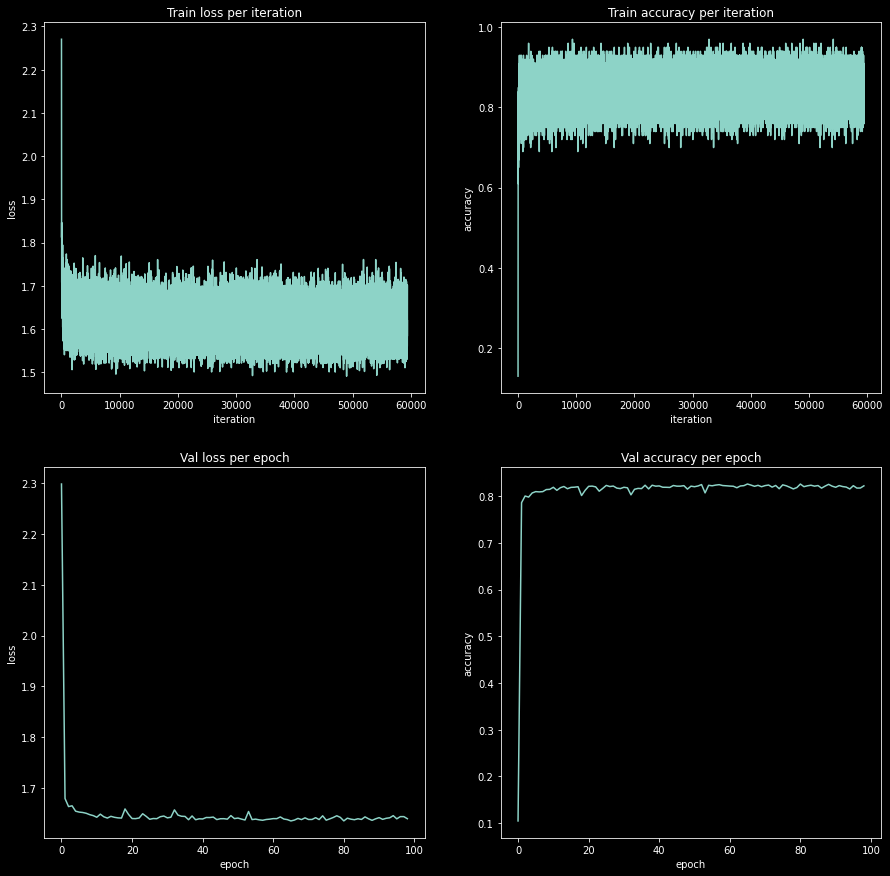

In [47]:
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax[0][0].plot(train_loss_iter)
ax[0][1].plot(train_acc_iter)
ax[1][0].plot(val_loss_epoch)
ax[1][1].plot(val_acc_epoch)


ax[0][0].set(title = 'Train loss per iteration', xlabel = 'iteration', ylabel = 'loss')
ax[0][1].set(title = 'Train accuracy per iteration', xlabel = 'iteration', ylabel = 'accuracy')
ax[1][0].set(title = 'Val loss per epoch', xlabel = 'epoch', ylabel = 'loss')
ax[1][1].set(title = 'Val accuracy per epoch', xlabel = 'epoch', ylabel = 'accuracy')

plt.show()

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента

Потому что делается корректировка на $\frac{1}{1 - \beta^t}$ для обоих гиперпараметров бета, что убирает их изначальное влияние и мат. ожидание оценки квадрата градиента сходится с его реальным квадратом.

* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Скорее всего, модель начала переобучаться где-то, начиная с 80 эпохи, потому что accuracy совсем перестала расти и даже немного снизилась.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитектур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие модели были лучше и как вы думаете почему?

In [44]:
plt.style.use('dark_background')

def train_model(model, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(1, 21):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0
        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            y_pred = model(imgs)

            loss = nn.CrossEntropyLoss()(y_pred, labels)
            loss.backward()
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).numpy()))

            optimizer.step()

        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                pred = model(imgs)
                loss = nn.CrossEntropyLoss()(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)
        
        clear_output()

        fig, ax = plt.subplots(1, 2, figsize = (15, 7))
        ax[0].set_title ('Train loss per iteration,\nval loss per epoch')
        ax[0].plot (train_loss_log, label = 'train', zorder = 1)
        points1 = np.array (val_loss_log)
        steps1 = list(range(0, len(train_loss_log) + 1, int(len(train_loss_log) / len(val_loss_log))))[1:]
        ax[0].scatter (steps1, val_loss_log, marker = '+', s = 180, c = 'white', label = 'val', zorder = 2)
        ax[0].set_xlabel ('iteration')
        ax[0].set_ylabel ('loss')
        ax[0].legend(loc = 'best')
        ax[0].grid()

        ax[1].set_title ('Train accuracy per iteration,\nval accuracy per epoch')
        ax[1].plot (train_acc_log, label = 'train', zorder = 1)
        points2 = np.array (val_acc_log)
        steps2 = list(range(0, len(train_acc_log) + 1, int(len(train_acc_log) / len(val_acc_log))))[1:]
        ax[1].scatter (steps2, val_acc_log, marker = '+', s = 180, c = 'white', label = 'val', zorder = 2)
        ax[1].set_xlabel ('iteration')
        ax[1].set_ylabel ('accuracy')
        ax[1].legend(loc = 'best')
        ax[1].grid()

        plt.show()

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

In [4]:
first_model = nn.Sequential(
    nn.Flatten (),
    nn.Linear (784 , 1000),
    nn.ReLU (),
    nn.Linear (1000 , 500),
    nn.ReLU(),
    nn.Linear (500, 10),
    nn.Softmax(dim = -1)
)

Естественно, на втором графике по x должно быть написано iteration, а по y - accuracy, но я заметила ошибку, когда все уже обучилось.....

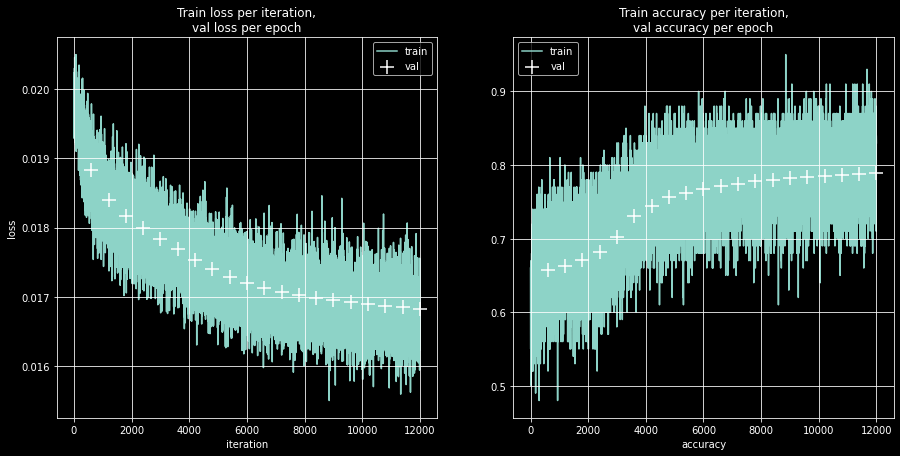

Train loss: 0.016771254016955693
Train acc: 0.7954
Val loss: 0.01682775079011917
Val acc: 0.7889


In [7]:
train_model (first_model, 
             torch.optim.SGD(first_model.parameters(), lr=0.001, momentum=0.9), 
             train_dataloader, 
             eval_dataloader)

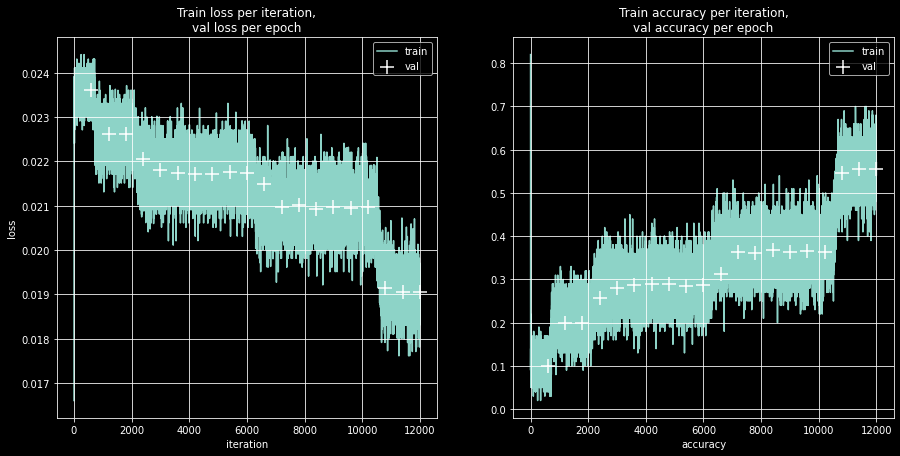

Train loss: 0.01906570121447245
Train acc: 0.5542
Val loss: 0.01906220499277115
Val acc: 0.5547


In [8]:
train_model (first_model, 
             torch.optim.RMSprop(first_model.parameters(), lr=0.001), 
             train_dataloader,
             eval_dataloader)

In [45]:
second_model = nn.Sequential(
    nn.Conv2d (1, 6, 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d (6, 6, 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d (2),
    nn.Conv2d (6, 12, 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d (12, 12, 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d (2),
    nn.Flatten(),
    nn.Linear (12 * 7 * 7, 120),
    nn.ReLU(),
    nn.Dropout (0.4),
    nn.Linear (120, 84),
    nn.ReLU (),
    nn.Linear (84 ,10),
    nn.Softmax (dim = -1)
)

Вот что произошло тут с обучением я искренне не понимаю, потому что первые раза 2 все училось хорошо, и с таким чудом помогал справиться перезапуск кернела, а потом помогать перестал, хотя во всех остальных моделях все ок(((

Ну хотя бы ошибка начала падать немного на 100500 эпохе

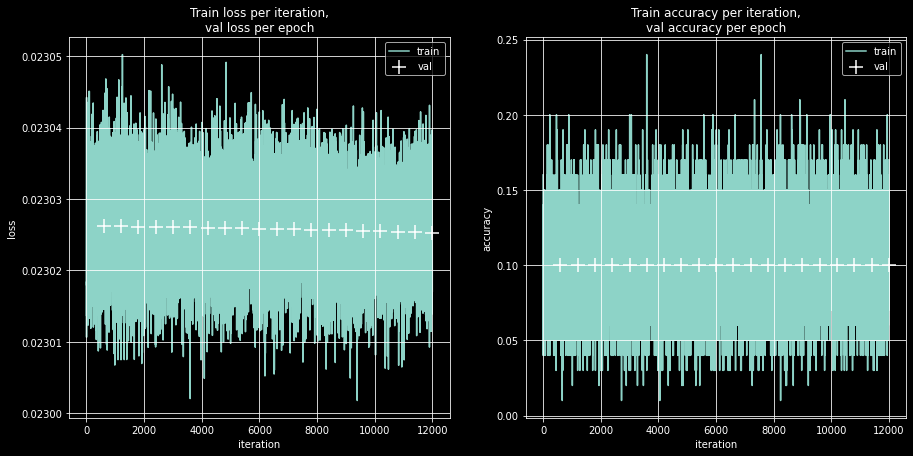

Train loss: 0.023025431764125824
Train acc: 0.10131666666666667
Val loss: 0.023025293922424316
Val acc: 0.1


In [46]:
train_model (second_model, 
             torch.optim.SGD(second_model.parameters(), lr=0.001, momentum=0.9), 
             train_dataloader,
             eval_dataloader)

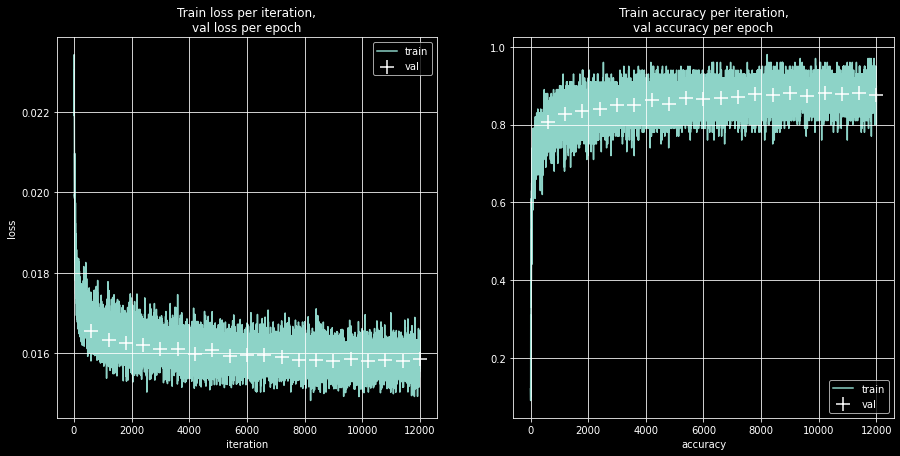

Train loss: 0.015782535396019617
Train acc: 0.8828
Val loss: 0.015842563700675966
Val acc: 0.8768


In [6]:
train_model (second_model, 
             torch.optim.RMSprop(second_model.parameters(), lr=0.001), 
             train_dataloader,
             eval_dataloader)

In [23]:
class ThirdModel(nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()
        self.conv1 = nn.Conv2d (1, 6, 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d (2)
        self.conv2 = nn.Conv2d (6, 6, 3, padding = 1)
        self.conv3 = nn.Conv2d (6, 6, 3, padding = 1)
        self.conv4 = nn.Conv2d (6, 6, 3, padding = 1)
        self.conv5 = nn.Conv2d (6, 6, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d (6)
        self.maxpool2 = nn.MaxPool2d (2)
        self.conv6 = nn.Conv2d (6, 12, 3, padding = 1)
        self.conv7 = nn.Conv2d (12, 12, 3, padding = 1)
        self.conv8 = nn.Conv2d (12, 12, 3, padding = 1)
        self.conv9 = nn.Conv2d (12, 12, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d (12)
        self.avgpool = nn.AvgPool2d(2, 1)
        self.fc1 = nn.Linear (12* 6 * 6, 784)
        self.fc2 = nn.Linear (784, 10)

    def forward(self, x):
      y = F.relu (self.conv1(x))
      y = self.maxpool1(y)
      y = F.relu (self.conv2(y))
      y = F.relu (self.conv3(y))
      y = F.relu (self.conv4(y))
      y = F.relu (self.conv5(y))
      y = F.relu (self.bn1(y))
      y = self.maxpool2 (y)
      y = F.relu (self.conv6(y))
      y = F.relu (self.conv7(y))
      y = F.relu (self.conv8(y))
      y = F.relu (self.conv9(y))
      y = F.relu (self.bn2(y))
      y = self.avgpool (y)
      y = y.view (-1, 12 * 6 * 6)
      y = F.relu (self.fc1 (y))
      y += nn.Flatten()(x)
      y = self.fc2 (y)

      return y


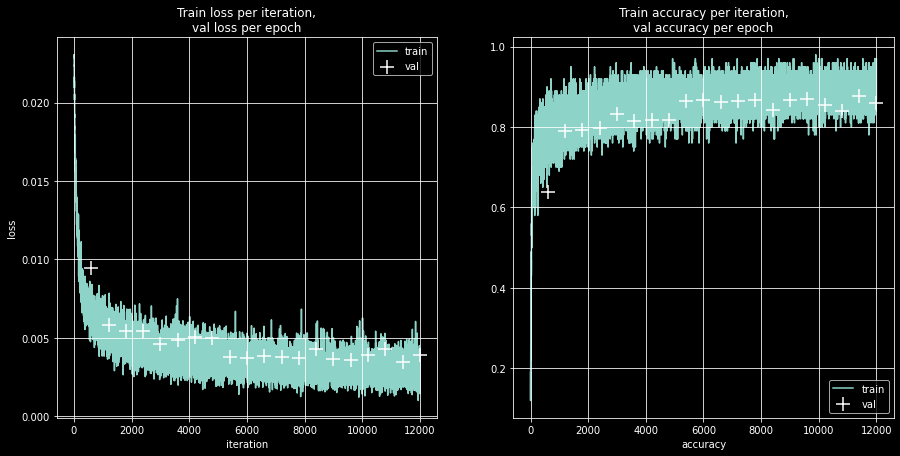

Train loss: 0.0028785303983837364
Train acc: 0.8955666666666666
Val loss: 0.0038812825888395307
Val acc: 0.8587


In [24]:
third_model = ThirdModel()

train_model (third_model,
             torch.optim.SGD(third_model.parameters(), lr=0.001, momentum=0.9), 
             train_dataloader,
             eval_dataloader)

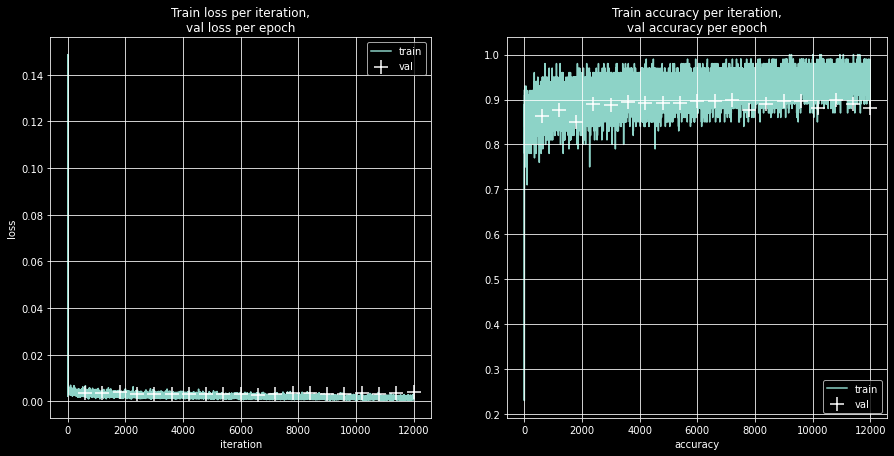

Train loss: 0.0013368792782227198
Train acc: 0.94955
Val loss: 0.003919115652143955
Val acc: 0.8814


In [25]:
train_model (third_model,
             torch.optim.RMSprop(third_model.parameters(), lr=0.001), 
             train_dataloader,
             eval_dataloader)

Лучше всего себя показали подобие VGG c RMSprop и подобие ResNet с одним пропускным каналом с RMSprop. За счет сверток и макспуллингов модели смогли уловить паттерны с картинок, чего не удалось модели только со сверточными слоями. RMSprop оптимизация помогла достичь меньше лосса, видимо, из-за того, что параметры модели обновляются с разной скоростью. ResNet также был чуть лучше с accuracy 0.88 и лоссом 0.0039 на тесте, скорее всего, за счет применения батчнорма.